# 시계열 분석 연습문제

## 문제 1 
이 데이터를 활용하여 조사기간동안 서울의 평균기온이 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA를 사용하여 분석하고 앞으로 1년간의 평균 기온을 시각화 하시오.

시각화 기간은 2023년 8월 6일을 기준으로 전후 1년간으로 한다.

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from scipy import interpolate

from datetime import datetime as dt
from datetime import timedelta
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb
from helper import set_datetime_index, exp_timedata
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller



### #01. 데이터 불러오기 

In [149]:
df = pd.read_excel('https://data.hossam.kr/E06/temperatures_seoul.xlsx',index_col='날짜')
df.head()

,평균기온(℃)
날짜,
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9


### #02. 데이터 전처리



In [150]:
df.dtypes

평균기온(℃)    float64
dtype: object

In [151]:
df.isnull().sum()

평균기온(℃)    0
dtype: int64

In [152]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

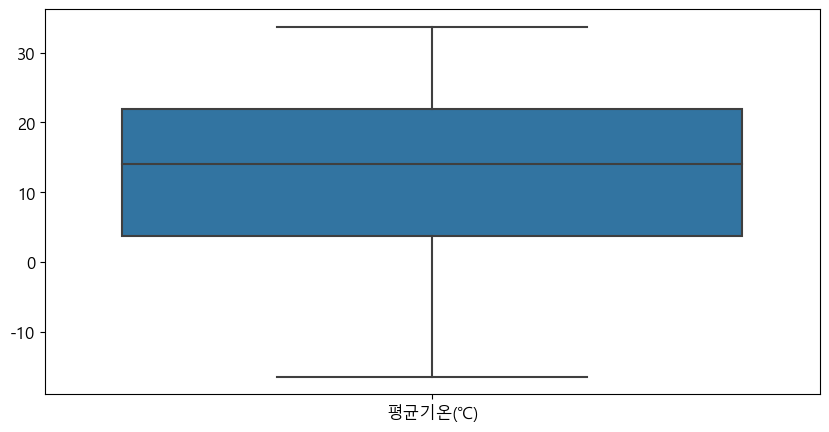

In [153]:
plt.figure()
sb.boxplot(data=df)
plt.show()
plt.close()

<Axes: xlabel='날짜'>

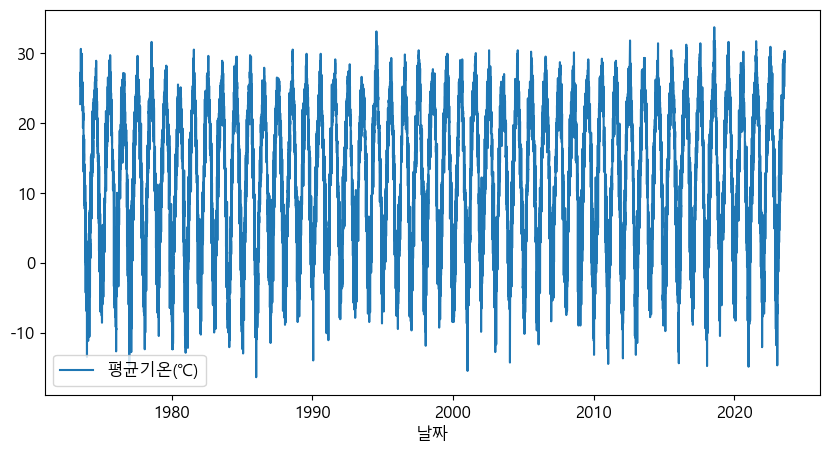

In [154]:
sb.lineplot(data=df)

### #03. 시계열 분해


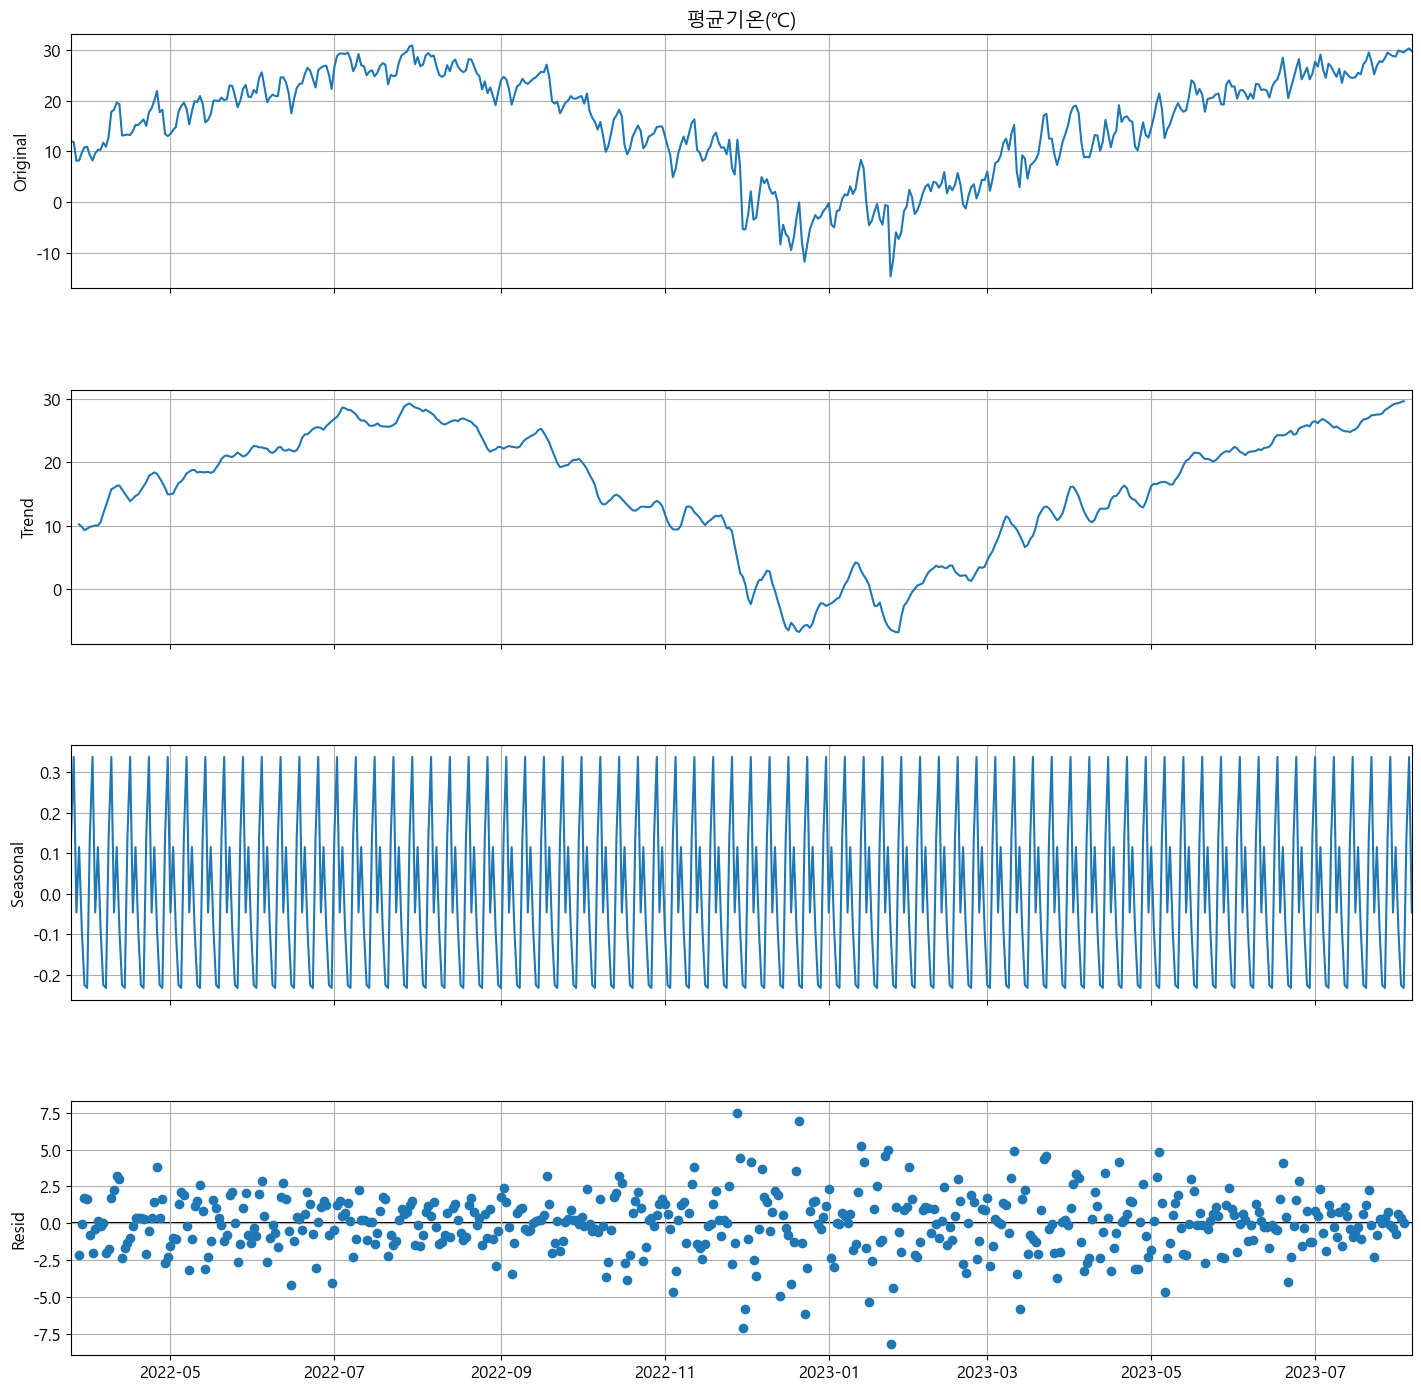

In [8]:
sd = seasonal_decompose(df['평균기온(℃)'].tail(500),model = "additive")

figure = sd.plot()
figure.set_figwidth(15)
figure.set_figheight(16)
fig,ax1,ax2,ax3,ax4 = figure.get_children()
figure.subplots_adjust(hspace = 0.4)
ax1.set_ylabel("Original")
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)



### #04. 정상성 여부 검정

In [73]:
ar = adfuller(df)
ardict = {
            '검정통계량 (ADF Statistic) ' : [ar[0]],
            'p-value ':[ar[1]],
            '최적 차수 ':[ar[2]],
            '관측치 개수':[ar[3]]
}
for key,value in ar[4].items() : 
    ardict['기각값 %s' % key] = value
        
stationality = ar[1]<0.05
ardict['데이터 정상성 여부(0=Flase,1=True)'] = stationality

ardf = pd.DataFrame(ardict,index = ['ADF']).T
ardf

,ADF
검정통계량 (ADF Statistic),-13.650422
p-value,0.0
최적 차수,45
관측치 개수,18253
기각값 1%,-3.430708
기각값 5%,-2.861698
기각값 10%,-2.566854
"데이터 정상성 여부(0=Flase,1=True)",True


In [74]:
df

,평균기온(℃)
날짜,
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9
...,...
2023-08-02,29.7
2023-08-03,29.5
2023-08-04,30.0


### #05. 모형결정 : ACF,PACF 테스트

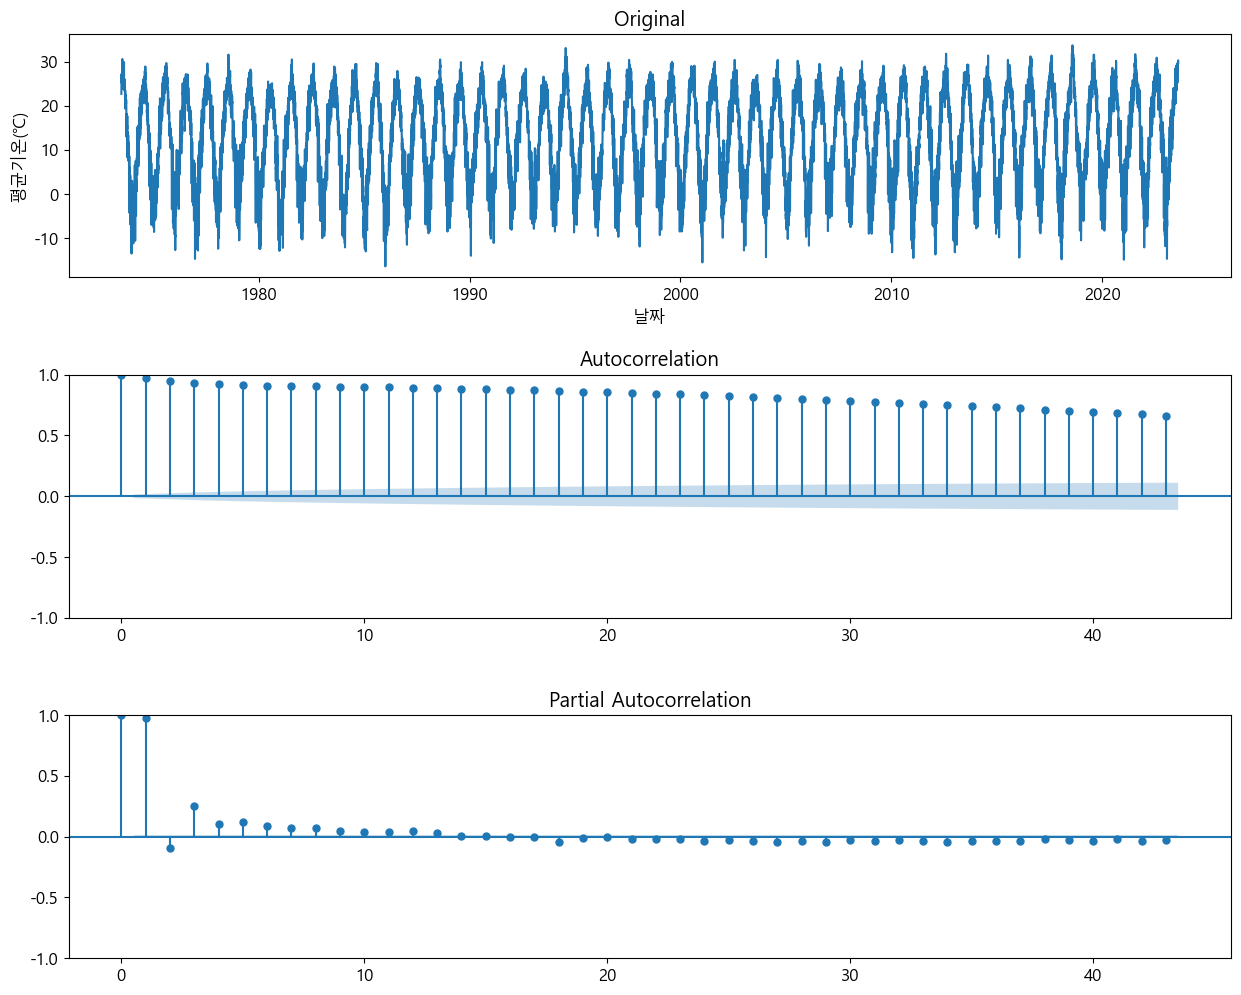

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)

ax1.title.set_text("Original")
sb.lineplot(data=df, x=df.index, y='평균기온(℃)', ax=ax1)

ax2.title.set_text("ACF Test")
plot_acf(df['평균기온(℃)'], ax=ax2)
        
ax3.title.set_text("PACF Test")
plot_pacf(df['평균기온(℃)'], ax=ax3)
        ## acf 랑 pacf 는 따로 행한르 ㅎㅈㄷㅇ 
plt.show()
plt.close()

### #06. ARIMA
AR 모형 사용



In [77]:
model = ARIMA(df['평균기온(℃)'],order = (2,0,0),seasonal_order=(2,0,0,12))
fit = model.fit()
print(fit.summary())

c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                          평균기온(℃)   No. Observations:                18299
Model:             ARIMA(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood              -41382.358
Date:                          Tue, 08 Aug 2023   AIC                          82776.715
Time:                                  10:30:28   BIC                          82823.603
Sample:                              07-01-1973   HQIC                         82792.122
                                   - 08-06-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6505      0.716     17.678      0.000      11.248      14.053
ar.L1          1.0658      0.006    165.417      0.

In [78]:
fv = fit.fittedvalues
fv.head()

날짜
1973-07-01    12.650527
1973-07-02    22.441031
1973-07-03    23.589001
1973-07-04    27.108616
1973-07-05    24.654294
dtype: float64

In [79]:
fc = fit.forecast(365)
fc.head()

2023-08-07    29.249998
2023-08-08    28.731503
2023-08-09    28.236392
2023-08-10    27.761612
2023-08-11    27.277589
Freq: D, Name: predicted_mean, dtype: float64

#### 시각화



In [81]:
last = df.index.max()
xmin=last - timedelta(days=365)
xmax = last + timedelta(days = 365)
ymax = df['평균기온(℃)'][xmin:xmax].max()

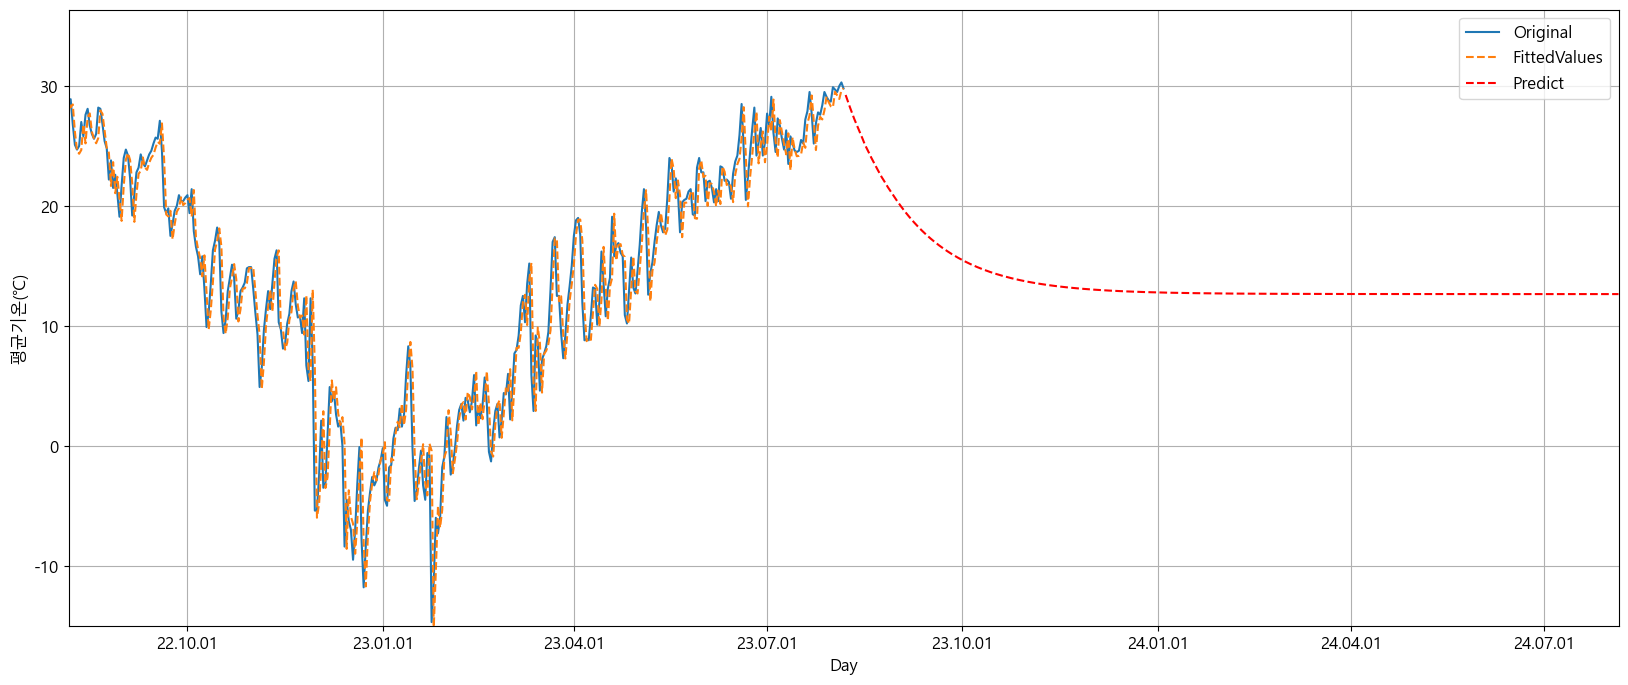

In [82]:
plt.figure(figsize=(20,8))

## 원본 데이터 
sb.lineplot(data=df,x=df.index , y='평균기온(℃)',label = 'Original')
## 원본에 대한 학습결과
sb.lineplot(x=fv.index,y=fv.values,label = 'FittedValues',linestyle = '--')
## 향후 120일 간의 예측치 
sb.lineplot(x=fc.index,y=fc.values,label = 'Predict', linestyle='--',color = 'red')

plt.xlabel('Day')
plt.ylabel('평균기온(℃)')
plt.legend()
plt.xlim([xmin, xmax])

plt.ylim([-15, ymax*1.2])

## 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearfmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearfmt)
plt.grid()
plt.show()
plt.close()

### #07. Auto ARIMA

In [85]:
my_p = 2   # AR의 차수 (검증한 결과를 활용)
my_d = 0    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 12    # 계절성 주기 (분석가가 판단)

model = auto_arima(
    y=df['평균기온(℃)'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,             # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=137777.710, Time=0.51 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=82946.553, Time=15.48 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=154307.360, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=82945.247, Time=1.04 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=82781.981, Time=2.78 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=82782.886, Time=19.73 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=82948.272, Time=0.85 sec

Best model:  ARIMA(2,0,0)(0,0,0)[12] intercept
Total fit time: 41.142 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                18299
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -41386.990
Date:                Tue, 08 Aug 2023   AIC                          82781.981
Time:                        10:33:19   BIC                          82813.239
Sam

In [25]:
fv = model.fittedvalues()
fv.head()
fc = model.predict(365)


In [26]:
last = df.index.max()
xmin = last - timedelta(days=365)
xmax = last + timedelta(days=365)
ymax = df['평균기온(℃)'][xmin:xmax].max()


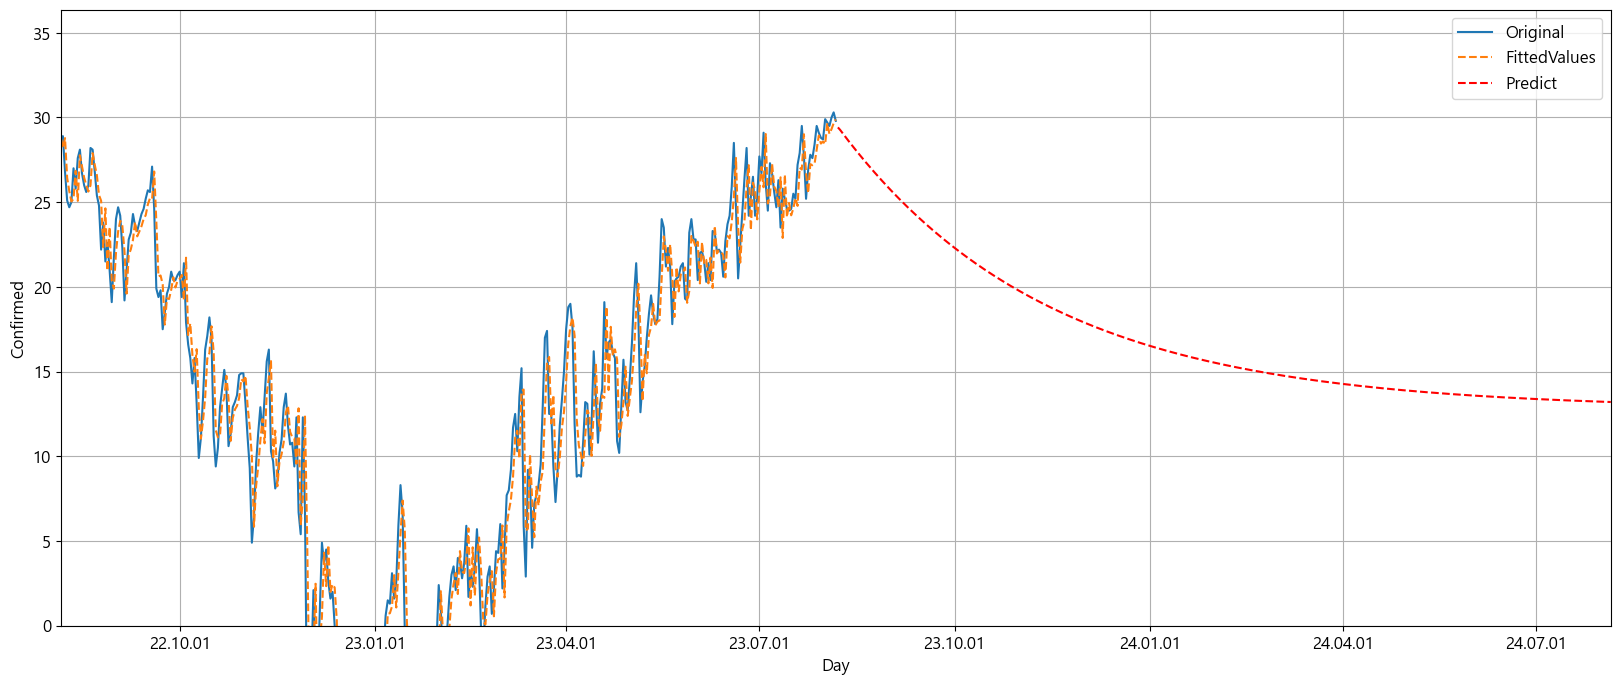

In [27]:
plt.figure(figsize=(20,8))

# 원본데이터
sb.lineplot(data=df,x=df.index,y='평균기온(℃)',label = 'Original')

## 원본에 대한 학습결과
# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 향후 120일간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

## 문제 2 
다음의 데이터는 1981년 01월부터 2023년 05월까지 전국에서 출생한 신생아 수를 조사하여 시,도별로 표시한 자료의 일부이다.

이 데이터를 활용하여 조사기간동안 전국에서 태어난 신생아 수가 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA중 자신이 사용 가능한 방식 하나를 선정하여 분석하고 앞으로 5년간의 신생아 수를 예측한 자료를 시각화 하시오.

단, 조사되지 않은 항목에 대해서는 신생아수가 0인 것으로 간주한다.


### #01. 데이터 불러오기

In [155]:
df= pd.read_excel('https://data.hossam.kr/E06/newborn.xlsx')
df.head()

,시점,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
0,1981년 01월,21461,7846,3547,2886,NaN,NaN,NaN,NaN,9685,3729,3002,6293,4956,8741,7454,7501,1050
1,1981년 02월,23389,8622,3588,3044,NaN,NaN,NaN,NaN,10352,3637,3161,7761,5326,8319,7446,8039,872
2,1981년 03월,15042,6284,2885,2456,NaN,NaN,NaN,NaN,7727,3158,2486,5214,3855,7566,6229,6714,805
3,1981년 04월,15231,5806,2783,2369,NaN,NaN,NaN,NaN,7321,3166,2230,4621,3634,6553,5548,6079,752
4,1981년 05월,16239,6225,2808,2468,NaN,NaN,NaN,NaN,7823,3234,2419,4879,3709,6564,5529,6222,821


### #02. 데이터 전처리


In [156]:
df['시점'] = df['시점'].str.replace("년",'')
df['시점'] = df['시점'].str.replace("월",'')

df['시점'].str.strip()


0      1981 01
1      1981 02
2      1981 03
3      1981 04
4      1981 05
        ...   
504    2023 01
505    2023 02
506    2023 03
507    2023 04
508    2023 05
Name: 시점, Length: 509, dtype: object

In [157]:
df['시점'] = pd.to_datetime(df['시점'])
df.dtypes

df.set_index(df['시점'],inplace=True)
df.drop('시점',inplace=True,axis=1)

C:\Users\hamin\AppData\Local\Temp\ipykernel_18016\237675081.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['시점'] = pd.to_datetime(df['시점'])


In [158]:
df.head()

,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
시점,,,,,,,,,,,,,,,,,
1981-01-01,21461,7846,3547,2886,NaN,NaN,NaN,NaN,9685,3729,3002,6293,4956,8741,7454,7501,1050
1981-02-01,23389,8622,3588,3044,NaN,NaN,NaN,NaN,10352,3637,3161,7761,5326,8319,7446,8039,872
1981-03-01,15042,6284,2885,2456,NaN,NaN,NaN,NaN,7727,3158,2486,5214,3855,7566,6229,6714,805
1981-04-01,15231,5806,2783,2369,NaN,NaN,NaN,NaN,7321,3166,2230,4621,3634,6553,5548,6079,752
1981-05-01,16239,6225,2808,2468,NaN,NaN,NaN,NaN,7823,3234,2419,4879,3709,6564,5529,6222,821


In [159]:
len(df)

509

In [160]:
df.isnull().sum()

서울특별시        0
부산광역시        0
대구광역시        0
인천광역시        0
광주광역시       60
대전광역시       96
울산광역시      192
세종특별자치시    372
경기도          0
강원도          0
충청북도         0
충청남도         0
전라북도         0
전라남도         0
경상북도         0
경상남도         0
제주특별자치도      0
dtype: int64

In [161]:
df[['광주광역시','대전광역시','울산광역시','세종특별자치시']].describe()

,광주광역시,대전광역시,울산광역시,세종특별자치시
count,449.000000,413.000000,317.000000,137.000000
mean,1260.527840,1260.617433,935.000000,234.153285
std,412.710325,361.697252,269.715239,89.037987
min,474.000000,509.000000,334.000000,67.000000
25%,984.000000,1077.000000,817.000000,131.000000
50%,1191.000000,1241.000000,939.000000,265.000000
75%,1582.000000,1537.000000,1047.000000,302.000000
max,2402.000000,2115.000000,1771.000000,392.000000


In [162]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

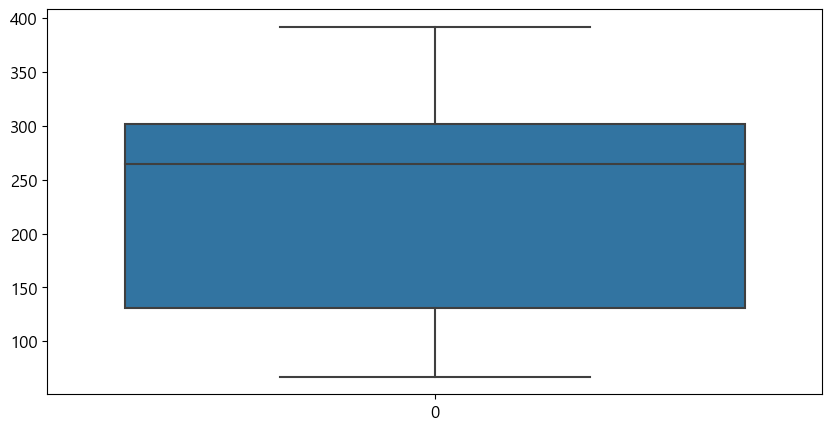

In [163]:
plt.figure()
sb.boxplot(data=df['세종특별자치시'])
plt.show()
plt.close()

### 결측치 처리

In [164]:
df.fillna(0,inplace=True)
df.isnull().sum()

서울특별시      0
부산광역시      0
대구광역시      0
인천광역시      0
광주광역시      0
대전광역시      0
울산광역시      0
세종특별자치시    0
경기도        0
강원도        0
충청북도       0
충청남도       0
전라북도       0
전라남도       0
경상북도       0
경상남도       0
제주특별자치도    0
dtype: int64

In [165]:
             
df['전국평균'] = df['서울특별시']+df['부산광역시']+df['대구광역시']+df['인천광역시']+df['광주광역시']+df['대전광역시']+df['울산광역시']+df['세종특별자치시']+df['경기도']
+df['강원도']+df['충청북도']+df['충청남도']+df['전라북도']+df['전라남도']+df['경상북도'] + +df['경상남도']+df['제주특별자치도'] 
df.head()

,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도,전국평균
시점,,,,,,,,,,,,,,,,,,
1981-01-01,21461,7846,3547,2886,0.0,0.0,0.0,0.0,9685,3729,3002,6293,4956,8741,7454,7501,1050,45425.0
1981-02-01,23389,8622,3588,3044,0.0,0.0,0.0,0.0,10352,3637,3161,7761,5326,8319,7446,8039,872,48995.0
1981-03-01,15042,6284,2885,2456,0.0,0.0,0.0,0.0,7727,3158,2486,5214,3855,7566,6229,6714,805,34394.0
1981-04-01,15231,5806,2783,2369,0.0,0.0,0.0,0.0,7321,3166,2230,4621,3634,6553,5548,6079,752,33510.0
1981-05-01,16239,6225,2808,2468,0.0,0.0,0.0,0.0,7823,3234,2419,4879,3709,6564,5529,6222,821,35563.0


In [166]:
df['전국평균'] = df['전국평균'] / 17

In [167]:
# ### 데이터 분리 (5년간)
# recent_df=df.iloc[-61:,:]
# recent_df

### #03. 시계열 분해

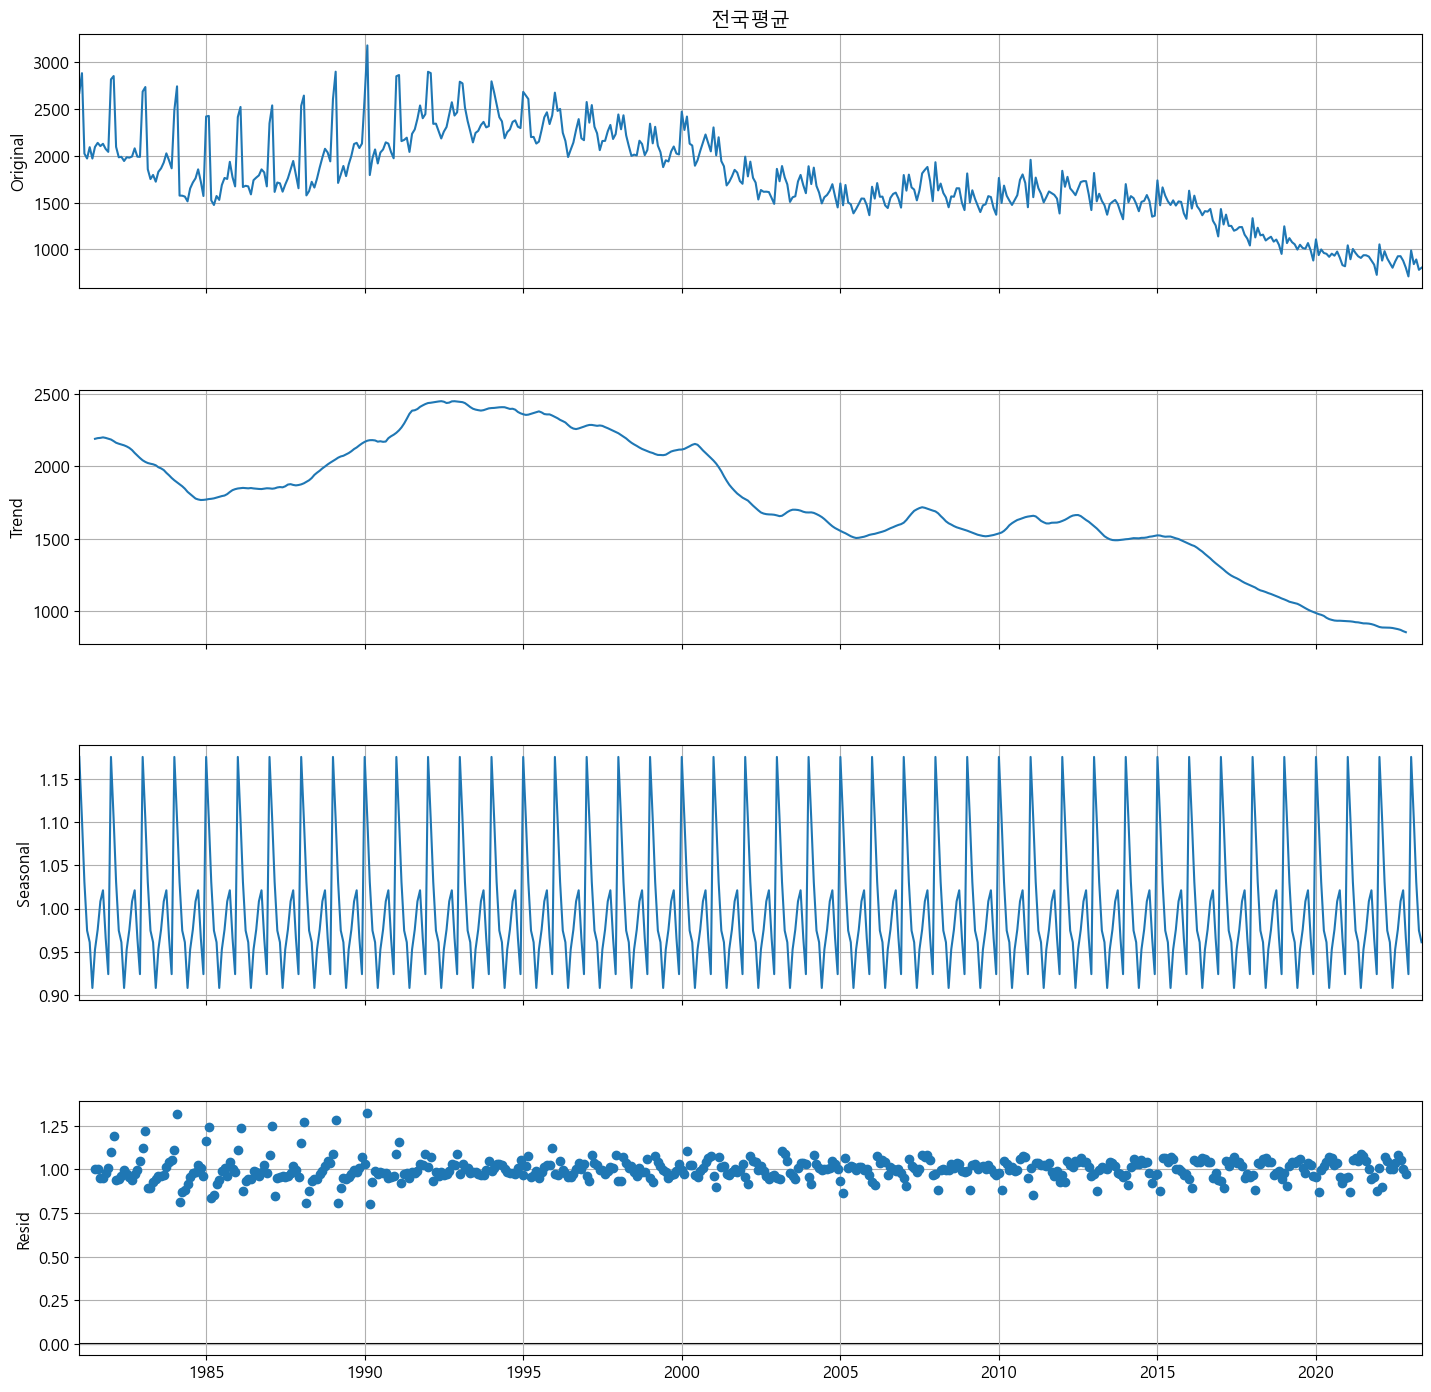

In [168]:
sd = seasonal_decompose(df['전국평균'],model = 'multiplicative')


figure = sd.plot()
figure.set_figwidth(15)
figure.set_figheight(16)
fig,ax1,ax2,ax3,ax4 = figure.get_children()
figure.subplots_adjust(hspace = 0.4)
ax1.set_ylabel("Original")
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)

### 정상성 여부 결정


In [169]:
df

,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도,전국평균
시점,,,,,,,,,,,,,,,,,,
1981-01-01,21461,7846,3547,2886,0.0,0.0,0.0,0.0,9685,3729,3002,6293,4956,8741,7454,7501,1050,2672.058824
1981-02-01,23389,8622,3588,3044,0.0,0.0,0.0,0.0,10352,3637,3161,7761,5326,8319,7446,8039,872,2882.058824
1981-03-01,15042,6284,2885,2456,0.0,0.0,0.0,0.0,7727,3158,2486,5214,3855,7566,6229,6714,805,2023.176471
1981-04-01,15231,5806,2783,2369,0.0,0.0,0.0,0.0,7321,3166,2230,4621,3634,6553,5548,6079,752,1971.176471
1981-05-01,16239,6225,2808,2468,0.0,0.0,0.0,0.0,7823,3234,2419,4879,3709,6564,5529,6222,821,2091.941176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,4079,1303,905,1428,626.0,675.0,519.0,313.0,6957,675,698,921,687,780,1041,1230,345,988.529412
2023-02-01,3284,1130,801,1187,588.0,650.0,436.0,278.0,5979,602,636,805,539,671,942,1139,272,843.117647
2023-03-01,3605,1170,905,1219,572.0,658.0,489.0,255.0,6306,640,725,826,589,714,923,1256,286,892.882353


In [174]:
df = df['전국평균']
df = pd.DataFrame(new_df)
df

,전국평균
시점,
1981-01-01,2672.058824
1981-02-01,2882.058824
1981-03-01,2023.176471
1981-04-01,1971.176471
1981-05-01,2091.941176
...,...
2023-01-01,988.529412
2023-02-01,843.117647
2023-03-01,892.882353


In [175]:
ar = adfuller(df['전국평균'])
ardict = {
            '검정통계량 (ADF Statistic) ' : [ar[0]],
            'p-value ':[ar[1]],
            '최적 차수 ':[ar[2]],
            '관측치 개수':[ar[3]]
}
for key,value in ar[4].items() : 
    ardict['기각값 %s' % key] = value
        
stationality = ar[1]<0.05
ardict['데이터 정상성 여부(0=Flase,1=True)'] = stationality

ardf = pd.DataFrame(ardict,index = ['ADF']).T
ardf

,ADF
검정통계량 (ADF Statistic),-0.259839
p-value,0.931003
최적 차수,13
관측치 개수,495
기각값 1%,-3.44363
기각값 5%,-2.867397
기각값 10%,-2.569889
"데이터 정상성 여부(0=Flase,1=True)",False


In [176]:
### 차분 ㄱㄱ 
df= df.diff().dropna()


In [177]:
ar = adfuller(df['전국평균'])
ardict = {
            '검정통계량 (ADF Statistic) ' : [ar[0]],
            'p-value ':[ar[1]],
            '최적 차수 ':[ar[2]],
            '관측치 개수':[ar[3]]
}
for key,value in ar[4].items() : 
    ardict['기각값 %s' % key] = value
        
stationality = ar[1]<0.05
ardict['데이터 정상성 여부(0=Flase,1=True)'] = stationality

ardf = pd.DataFrame(ardict,index = ['ADF']).T
ardf

,ADF
검정통계량 (ADF Statistic),-5.25279
p-value,0.000007
최적 차수,12
관측치 개수,495
기각값 1%,-3.44363
기각값 5%,-2.867397
기각값 10%,-2.569889
"데이터 정상성 여부(0=Flase,1=True)",True


### ACF PACF 테스트 


p = 2 , q = 0 , d = 1

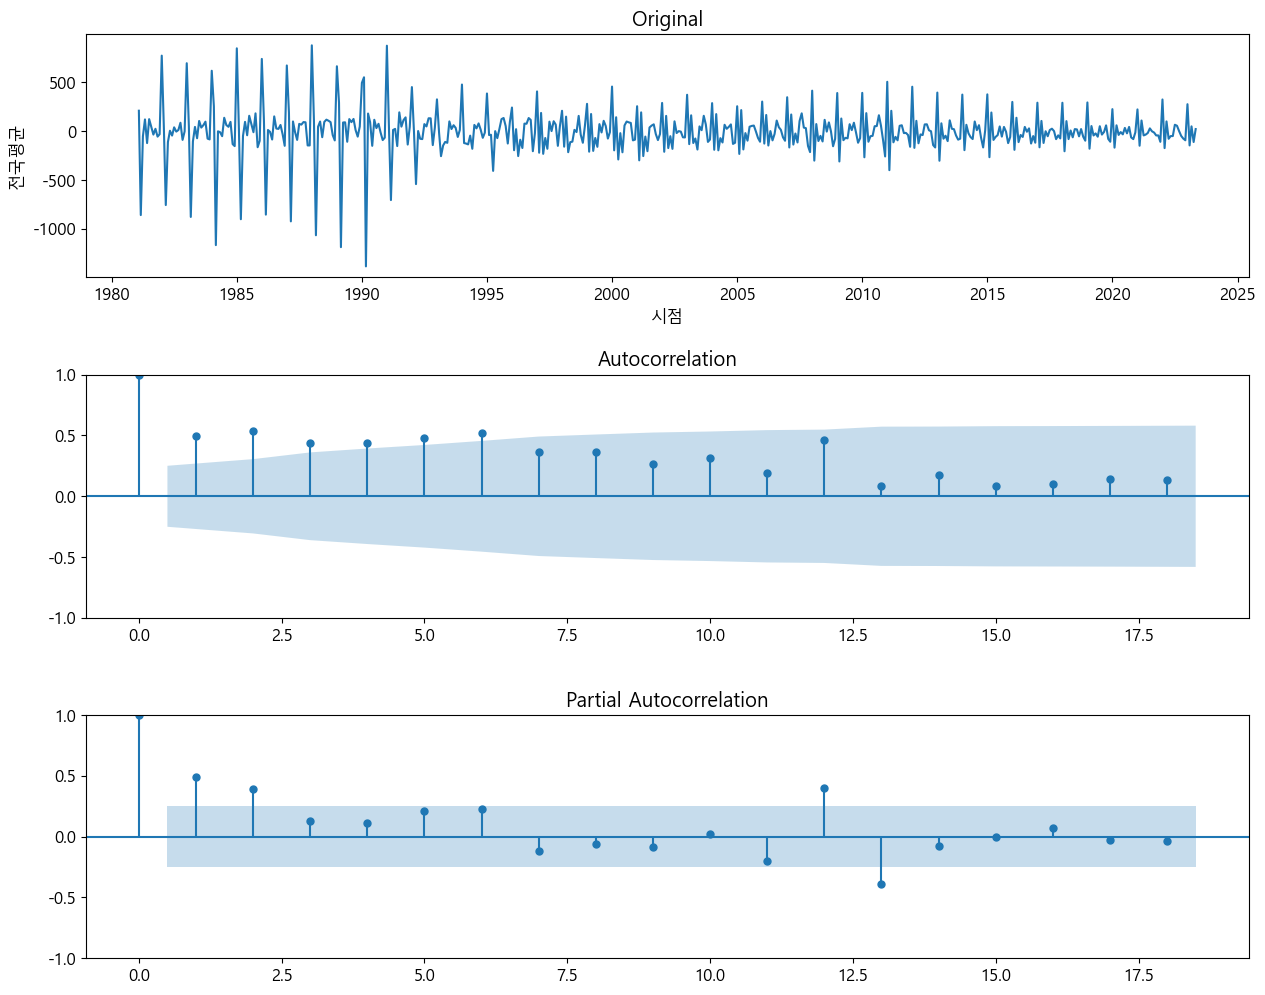

In [179]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)

ax1.title.set_text("Original")
sb.lineplot(data=df, x=df.index, y='전국평균', ax=ax1)

ax2.title.set_text("ACF Test")
plot_acf(recent_df['전국평균'], ax=ax2)
        
ax3.title.set_text("PACF Test")
plot_pacf(recent_df['전국평균'], ax=ax3)
        ## acf 랑 pacf 는 따로 행한르 ㅎㅈㄷㅇ 
plt.show()
plt.close()

In [185]:
df

,전국평균
시점,
1981-02-01,210.000000
1981-03-01,-858.882353
1981-04-01,-52.000000
1981-05-01,120.764706
1981-06-01,-121.411765
...,...
2023-01-01,276.705882
2023-02-01,-145.411765
2023-03-01,49.764706


In [186]:
model = ARIMA(df['전국평균'],order = (2,1,0),seasonal_order=(2,1,0,12))
fit = model.fit()
print(fit.summary())

c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                             전국평균   No. Observations:                  508
Model:             ARIMA(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2940.459
Date:                          Tue, 08 Aug 2023   AIC                           5890.918
Time:                                  14:16:53   BIC                           5911.941
Sample:                              02-01-1981   HQIC                          5899.171
                                   - 05-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9885      0.024    -40.474      0.000      -1.036      -0.941
ar.L2         -0.4904      0.027    -18.015      0.

In [187]:
fv = fit.fittedvalues
fv.head()

시점
1981-02-01      0.000000
1981-03-01    208.510112
1981-04-01   -843.556803
1981-05-01    -66.394227
1981-06-01    116.525902
dtype: float64

In [188]:
fc = fit.forecast(365)
fc.head()

2023-06-01   -86.459910
2023-07-01    66.711566
2023-08-01    47.080178
2023-09-01   -11.721562
2023-10-01   -39.507110
Freq: MS, Name: predicted_mean, dtype: float64

In [189]:
last = df.index.max()
xmin=last - timedelta(days=60)
xmax = last + timedelta(days = 60)
ymax = df['전국평균'][xmin:xmax].max()

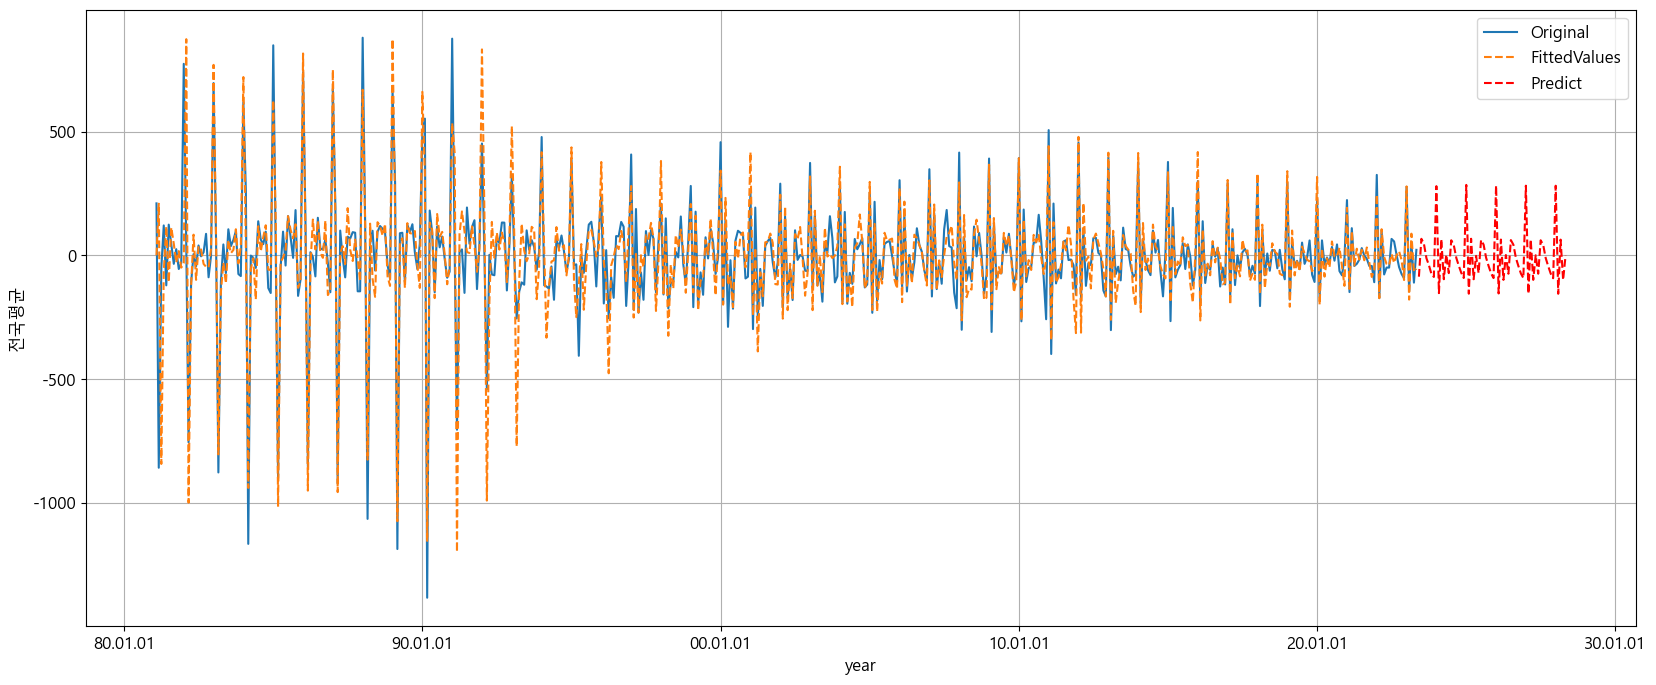

In [195]:
plt.figure(figsize=(20,8))

## 원본 데이터 
sb.lineplot(data=df,x=df.index , y='전국평균',label = 'Original')
## 원본에 대한 학습결과
sb.lineplot(x=fv.index,y=fv.values,label = 'FittedValues',linestyle = '--')
## 향후 120일 간의 예측치 
sb.lineplot(x=fc.index,y=fc.values,label = 'Predict', linestyle='--',color = 'red')

plt.xlabel('year')
plt.ylabel('전국평균')
plt.legend()


## 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearfmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearfmt)
plt.grid()
plt.show()
plt.close()

In [192]:
my_p = 2   # AR의 차수 (검증한 결과를 활용)
my_d = 1    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 12    # 계절성 주기 (분석가가 판단)

model = auto_arima(
    y=df['전국평균'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,             # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6359.207, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6029.604, Time=0.49 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6044.793, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=6022.647, Time=1.17 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=6306.153, Time=0.99 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5890.918, Time=2.24 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5897.805, Time=0.65 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=5892.915, Time=4.90 sec

Best model:  ARIMA(2,1,0)(2,1,0)[12]          
Total fit time: 10.681 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  508
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2940.459
Date:                            Tue, 08 Aug 2023   AIC              

In [193]:
fv = model.fittedvalues()
fv.head()
fc = model.predict(60)


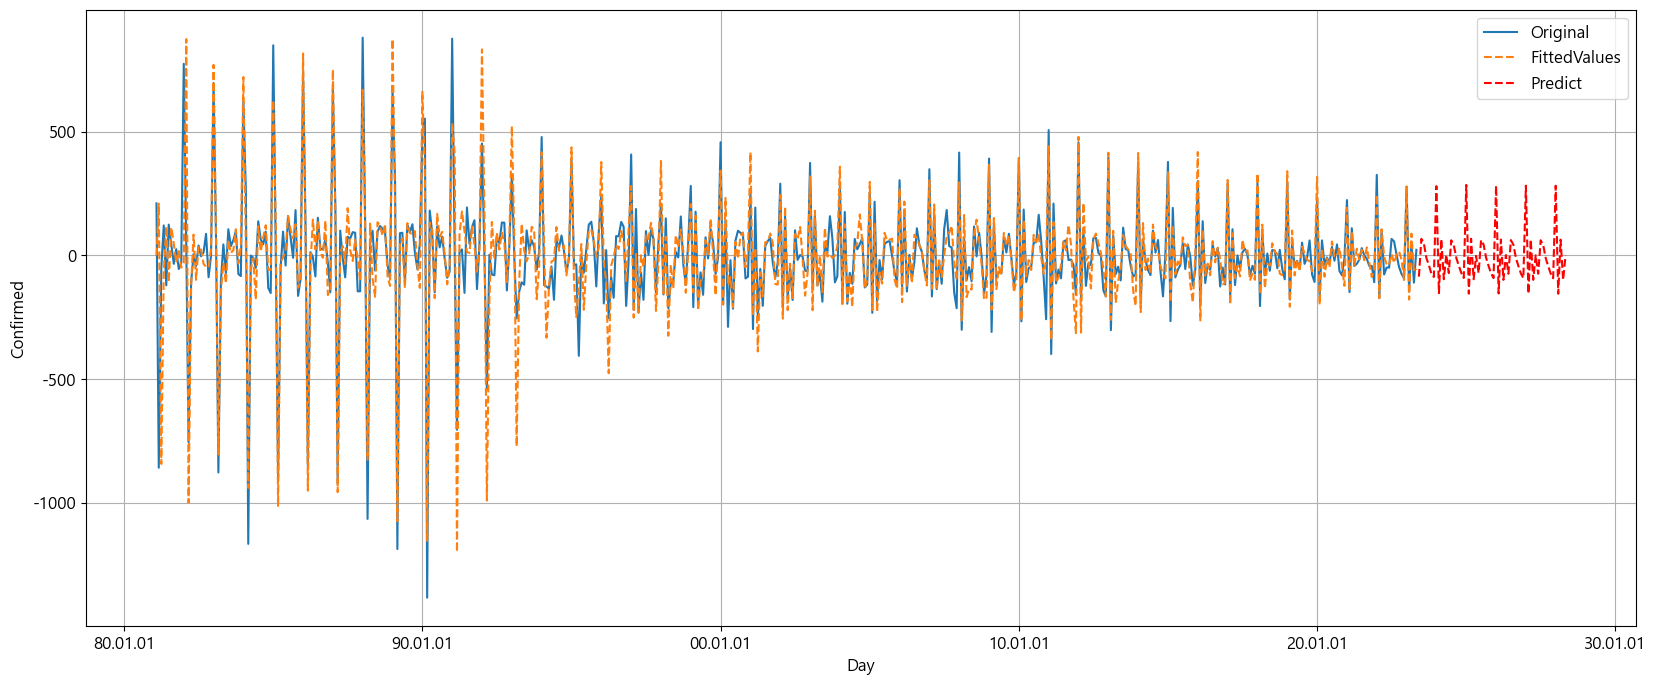

In [194]:
plt.figure(figsize=(20,8))

# 원본데이터
sb.lineplot(data=df,x=df.index,y='전국평균',label = 'Original')

## 원본에 대한 학습결과
# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 향후 120일간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()


# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()